<a href="https://colab.research.google.com/github/Curru12/Programacion-UIS/blob/main/Deteccion_de_fraudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
POSIBLES_RUTAS = ["/content/transactions.csv", "/transactions.csv"]
path = None
for p in POSIBLES_RUTAS:
  if os.path.exists(p):
    path = p
    break
assert path is not None,"transactions.csv not found. Please add it to input."
print("Using file:", path)
df = pd.read_csv(path)
print(df.shape)
df.head(3)

Using file: /content/transactions.csv
(299695, 17)


,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0


In [15]:
if 'transaction_time' in df.columns:
    print("The 'transaction_time' column exists in the DataFrame.")
else:
    print("The 'transaction_time' column does NOT exist in the DataFrame.")

The 'transaction_time' column exists in the DataFrame.


In [16]:
if 'transaction_time' in df.columns:
    df['transaction_time'] = pd.to_datetime(df['transaction_time'], errors='coerce')
    # 2. Extrae los componentes importantes del tiempo
    df['hour'] = df['transaction_time'].dt.hour
    df['day_of_week'] = df['transaction_time'].dt.dayofweek
    df['month'] = df['transaction_time'].dt.month
    #Convierte las horas,semanas a coordenadas circulares
    #Conversion de las horas
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    #Convercion de semanas
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Removed 'day_of_week' from the drop list to keep it for plotting.
    df = df.drop(columns=['transaction_time', 'month'])
    print(df.head())
else:
    print("Error: The 'transaction_time' column was not found in the DataFrame. Please ensure the data loading cell was executed correctly.")

   transaction_id  user_id  account_age_days  total_transactions_user  \
0               1        1               141                       47   
1               2        1               141                       47   
2               3        1               141                       47   
3               4        1               141                       47   
4               5        1               141                       47   

   avg_amount_user  amount country bin_country channel merchant_category  ...  \
0           147.93   84.75      FR          FR     web            travel  ...   
1           147.93  107.90      FR          FR     web            travel  ...   
2           147.93   92.36      FR          FR     app            travel  ...   
3           147.93  112.47      FR          FR     web           fashion  ...   
4           147.93  132.91      FR          US     web       electronics  ...   

   cvv_result  three_ds_flag  shipping_distance_km  is_fraud  hour  \
0   

In [17]:
print("Nulls per column:")
print(df.isnull().sum().sort_values(ascending=False).head(10))


df['country_match'] = (df['country'] == df['bin_country']).astype(int)
# 'hour' column will now exist from the previous cell
df['night_flag'] = df['hour'].isin([22,23,0,1,2,3,4,5]).astype(int)

summary = {
    "rows": len(df),  # Total de transacciones: 999,605
    "unique_users": df['user_id'].nunique(),  # Usuarios únicos: 6,088
    "fraud_Lv": df['is_fraud'].sum(),  # Cantidad de fraudes
    "fraud_rate": df['is_fraud'].mean(),  # Tasa de fraude: ~6.62%
    "country_match_rate": df['country_match'].mean(),  # Coincidencia país: ~6.72%
    "avg_tx_per_user": len(df) / df['user_id'].nunique()  # Promedio: ~49.95 transacciones por usuario
}
print("\nSummary:")
for key, value in summary.items():
    print(f"{key}: {value}")

Nulls per column:
transaction_id             0
user_id                    0
account_age_days           0
total_transactions_user    0
avg_amount_user            0
amount                     0
country                    0
bin_country                0
channel                    0
merchant_category          0
dtype: int64

Summary:
rows: 299695
unique_users: 6000
fraud_Lv: 6612
fraud_rate: 0.02206243013730626
country_match_rate: 0.9208194998248219
avg_tx_per_user: 49.94916666666666


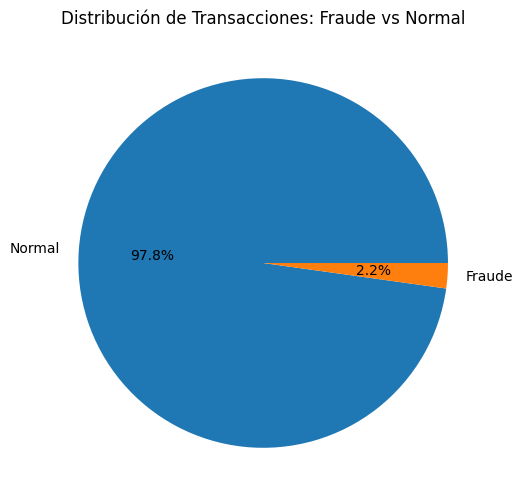

In [18]:
#Graficas de analisis de todos los datos
plt.figure(figsize=(8, 6))
df['is_fraud'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                  labels=['Normal', 'Fraude'])
plt.title('Distribución de Transacciones: Fraude vs Normal')
plt.ylabel('')
plt.show()

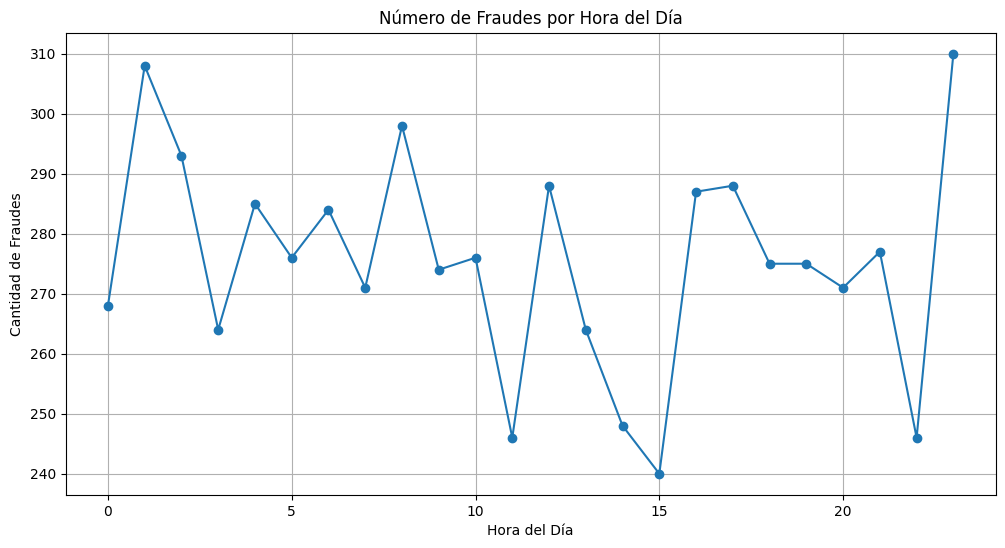

In [19]:
  plt.figure(figsize=(12, 6))
  fraud_by_hour = df[df['is_fraud'] == 1]['hour'].value_counts().sort_index()
  plt.plot(fraud_by_hour.index, fraud_by_hour.values, marker='o')
  plt.title('Número de Fraudes por Hora del Día')
  plt.xlabel('Hora del Día')
  plt.ylabel('Cantidad de Fraudes')
  plt.grid(True)
  plt.show()

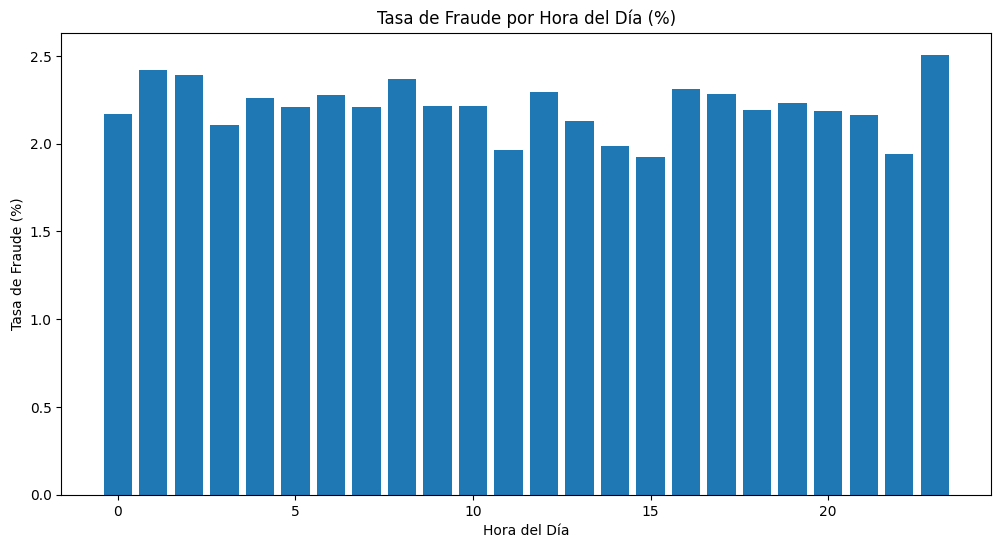

In [20]:
plt.figure(figsize=(12, 6))
fraud_rate_by_hour = df.groupby('hour')['is_fraud'].mean() * 100
plt.bar(fraud_rate_by_hour.index, fraud_rate_by_hour.values)
plt.title('Tasa de Fraude por Hora del Día (%)')
plt.xlabel('Hora del Día')
plt.ylabel('Tasa de Fraude (%)')
plt.show()

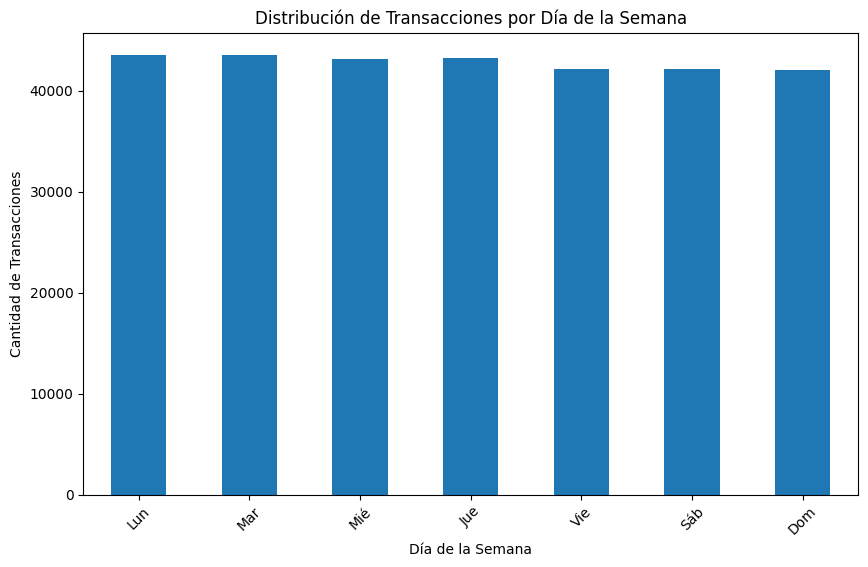

In [21]:
# Recuperar día de la semana si es necesario, o usar las coordenadas circulares
days = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
plt.figure(figsize=(10, 6))
df['day_of_week'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Transacciones por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de Transacciones')
plt.xticks(range(7), days, rotation=45)
plt.show()

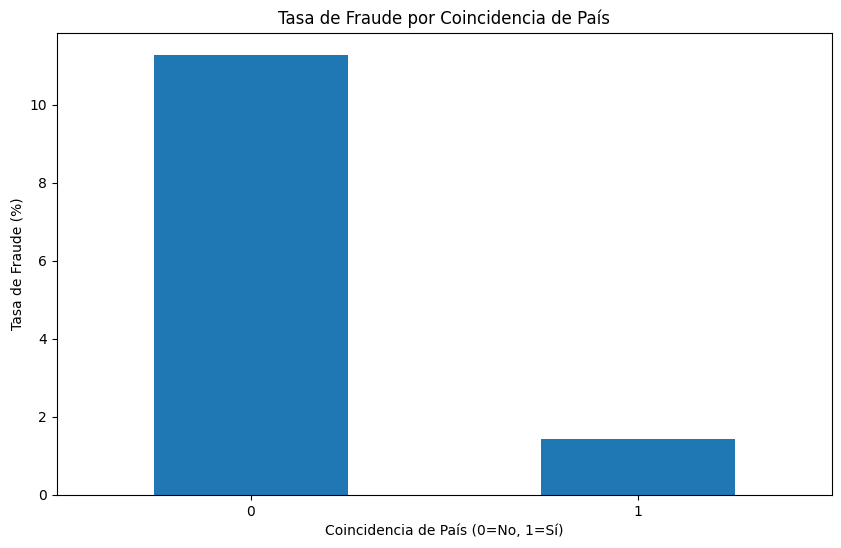

In [22]:
plt.figure(figsize=(10, 6))
country_fraud = df.groupby('country_match')['is_fraud'].mean() * 100
country_fraud.plot(kind='bar')
plt.title('Tasa de Fraude por Coincidencia de País')
plt.xlabel('Coincidencia de País (0=No, 1=Sí)')
plt.ylabel('Tasa de Fraude (%)')
plt.xticks(rotation=0)
plt.show()

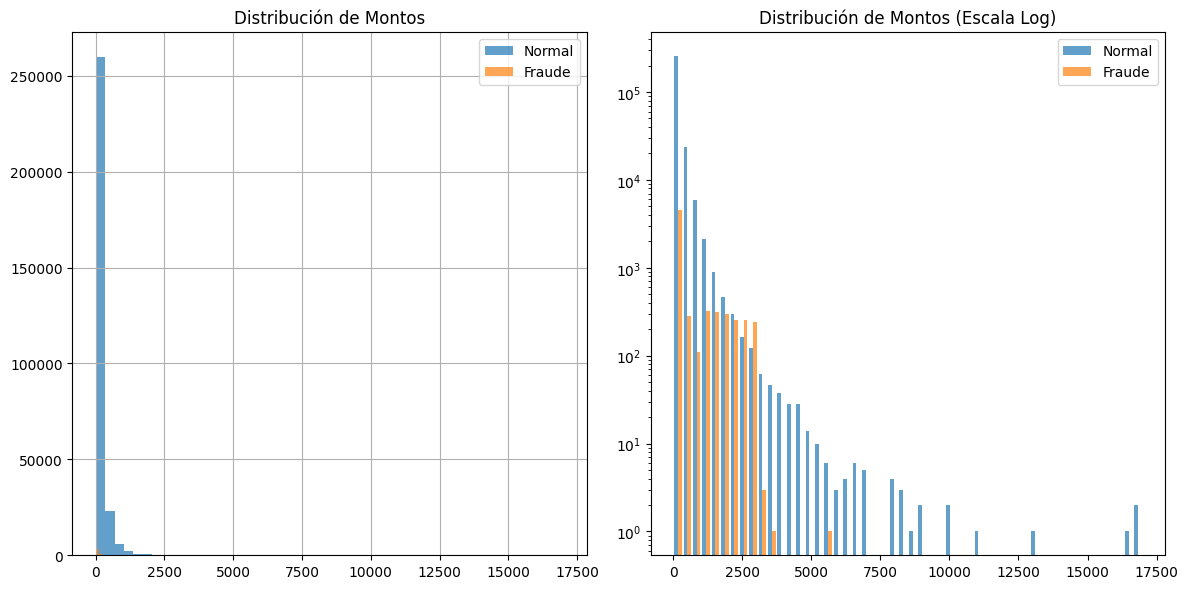

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df[df['is_fraud'] == 0]['amount'].hist(bins=50, alpha=0.7, label='Normal')
df[df['is_fraud'] == 1]['amount'].hist(bins=50, alpha=0.7, label='Fraude')
plt.title('Distribución de Montos')
plt.legend()

plt.subplot(1, 2, 2)
# Log scale para mejor visualización
plt.hist([df[df['is_fraud'] == 0]['amount'], df[df['is_fraud'] == 1]['amount']],
         bins=50, alpha=0.7, label=['Normal', 'Fraude'])
plt.yscale('log')
plt.title('Distribución de Montos (Escala Log)')
plt.legend()
plt.tight_layout()
plt.show()

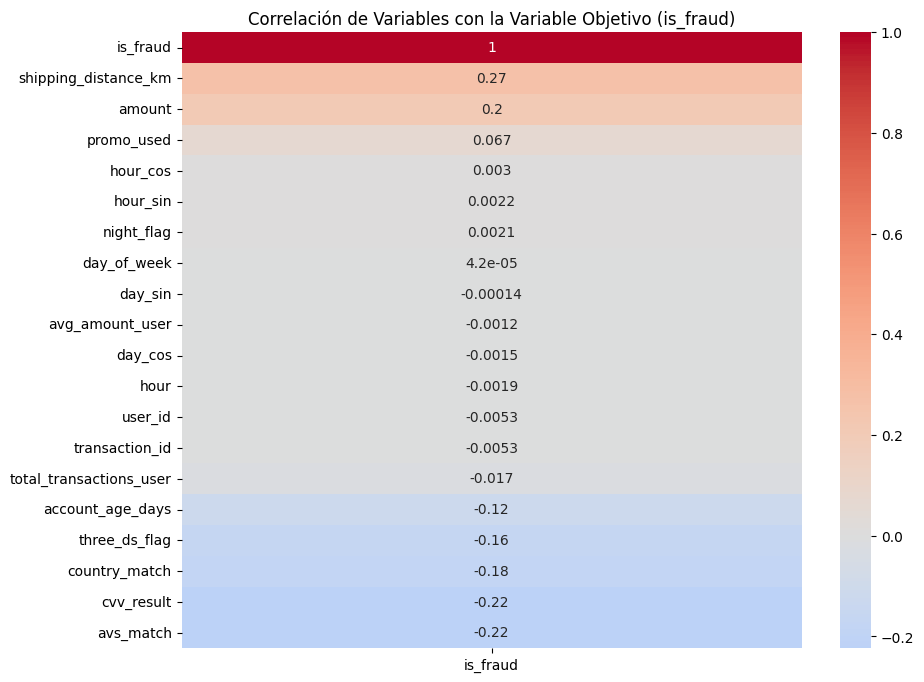

In [24]:
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
import seaborn as sns
sns.heatmap(correlation_matrix[['is_fraud']].sort_values('is_fraud', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlación de Variables con la Variable Objetivo (is_fraud)')
plt.show()